In [237]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import pygame
import matplotlib.pyplot as plt


In [238]:
#A simple neural network architecture
class genetic_network(nn.Module):
    def __init__(self):
        super().__init__()
        self.architecture= nn.Sequential(
        nn.Linear(48,128),
        nn.Tanh(),
        nn.Linear(128,2),
        )
        self.apply(self._init_weights)
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.uniform_(m.weight, a=-1, b=1)   
    def forward(self,x):
        out = self.architecture(x)
        return out
#A function to get the weights of the nn
def gene(network):
    flat_params = torch.cat([p.view(-1) for p in network.parameters()])
    return flat_params

def set_gene(gene):
    model = genetic_network()
    pointer = 0
    for param in model.parameters():
        numel = param.numel()
        new_values = gene[pointer:pointer+numel].view_as(param)
        with torch.no_grad():
            param.copy_(new_values)
        pointer+=numel
    return model

In [239]:
#Recombination strategies
def recombine_weighted(gene_a,gene_b,alpha):
    return (gene_a*alpha + (1-alpha)*gene_b,gene_b*alpha + (1-alpha)*gene_a)

#def 1 point crossover
def crossover(gene_a,gene_b):
    m = int(len(gene_a) / 2)
    child1 = torch.cat([gene_a[:m], gene_b[m:]], dim=0)
    child2 = torch.cat([gene_b[:m], gene_a[m:]], dim=0)
    return child1, child2

In [ ]:
#A factor to multiply buying and selling price with
sell_coeff = 1
buy_coeff = 10
time = 0.2

class Player:
    #Initialize citizen
    def __init__(self,start_x,start_y,speed,team):
        self.score = 0
        self.x = start_x
        self.y = start_y
        self.initial_x = start_x
        self.initial_y = start_y
        self.speed = speed
        self.team = team
        self.mind = genetic_network()
    
    #Update citizen actions
    def update(self,team1,team2,ball_x,ball_y,delta_time,borderx,bordery):
        #The input to our network
        values = [self.x, self.y, ball_x, ball_y]

        # Append all (x,y) from team1
        for p in team1:
            values.extend([p.x, p.y])

        # Append all (x,y) from team2
        for p in team2:
            values.extend([p.x, p.y])

        # Convert to tensor
        inp = torch.tensor(values, dtype=torch.float32)
        self.decision = self.mind(inp)
        #First we want to get a direction to move in
        destx = float((F.tanh(self.decision[0])+1)/2.0)*borderx
        desty = float((F.tanh(self.decision[1])+1)/2.0)*bordery

        dirx = destx-self.x
        diry = desty - self.y

        #Normalize the values
        norm = (dirx**2 + diry**2)**0.5

        if(norm>20):
            dirx = dirx/(norm+1e-5)
            diry = diry/(norm+1e-5)

            #Update position of the person
            self.x += dirx*self.speed*delta_time
            self.y += diry*self.speed*delta_time

        if(self.x<0):
            self.x=0
        if(self.y<0):
            self.y =0
        if(self.x>borderx):
            self.x = borderx
        if(self.y>bordery):
            self.y = bordery

class Ball:
    def __init__(self,start_x,start_y,speed):
        self.x = start_x
        self.y = start_y
        self.speed = speed
        self.dirx = 0
        self.diry = 0
        self.mind = genetic_network()
        self.log = []
        self.dirx = 1
        self.diry = -1
    def update(self,team1,team2,radius,borderx,bordery,goal_reward,gamma,delta_time):
        for i in range(0,len(team1)):
            p = team1[i]
            dirx = self.x-p.x
            diry = self.y-p.y

            norm = (dirx**2 + diry**2)**0.5
            if(norm<radius and norm>0):
                self.dirx += dirx/norm
                self.diry += diry/norm
                self.log.append((1,i))
                #If it kick its in the pos x direction, slightly reward it
                if(dirx>0):
                    team1[i].score += 0.25
        
        for i in range(0,len(team2)):
            p = team2[i]
            dirx = self.x-p.x
            diry = self.y-p.y

            norm = (dirx**2 + diry**2)**0.5
            if(norm<radius and norm>0):
                self.dirx += dirx/norm
                self.diry += diry/norm
                self.log.append((2,i))
                #If it kick its in the neg x direction, slightly reward it
                if(dirx<0):
                    team2[i].score += 0.25

        norm2 = (self.dirx**2 + self.diry**2)**0.5

        if(norm2>0):
            self.dirx = self.dirx/norm2
            self.diry = self.diry/norm2
        
        #Update position
        self.x += self.dirx*self.speed*delta_time
        self.y += self.diry*self.speed*delta_time


        #Team 1 scores
        if(self.x>borderx):
            self.x=borderx/2
            self.y = bordery/2
            reward = goal_reward
            for i in range(len(self.log)-1,-1,-1):
                team = self.log[i][0]
                id = self.log[i][1]
                if(team==1):
                    team1[id].score += reward
                else:
                    team2[id].score -= reward
                reward = reward*gamma
            
            self.log = []
            self.dirx = 1
            self.diry = -1

            for i in range(0,len(team1)):
                team1[i].x = random.randint(0,200)
                team1[i].y = random.randint(0,600) 
            for i in range(0,len(team2)):
                team2[i].x = random.randint(600,800)
                team2[i].y = random.randint(0,600) 
        
        #Team 2 scores
        if(self.x<0):
            self.x=borderx/2
            self.y = bordery/2
            reward = goal_reward
            for i in range(len(self.log)-1,-1,-1):
                team = self.log[i][0]
                id = self.log[i][1]
                if(team==1):
                    team1[id].score -= reward
                else:
                    team2[id].score += reward
                reward = reward*gamma
            
            self.log = []
            self.dirx = 1
            self.diry = -1   
            for i in range(0,len(team1)):
                team1[i].x = random.randint(0,200)
                team1[i].y = random.randint(0,600) 
            for i in range(0,len(team2)):
                team2[i].x = random.randint(600,800)
                team2[i].y = random.randint(0,600) 
        
        if(self.y<0 and self.diry<=0):
            self.diry *= -1 
        
        if(self.y>bordery and self.diry>=0):
            self.diry *=-1

In [241]:
#Formula for generating next generation
def generate(group,min_x,max_x,min_y,max_y):
    group = sorted(group,key=lambda b:b.score,reverse=True)
    new_group = []
    #Add the top 30%performers to the next set of farmers
    for i in range(0,int(0.3*len(group))):
        f = Player(random.randint(min_x,max_x),random.randint(min_y,max_y),group[i].speed,group[i].team)
        new_group.append(f)

    #Add some recombinations
    while len(new_group)<len(group):
        min_score = (min(f.score for f in group)-0.1)
        chosen_one = random.choices(group, weights=[f.score-min_score for f in group], k=1)[0]
        remaining = [f for f in group if f != chosen_one]
        remaining_weights = [f.score-min_score for f in remaining]
        chosen_two = random.choices(remaining, weights=remaining_weights, k=1)[0]
        gene_a = gene(chosen_one.mind)
        gene_b = gene(chosen_two.mind)
        mutated = crossover(gene_a,gene_b)
        mutated2 = recombine_weighted(gene_a,gene_b,0.4)
        f = Player(random.randint(min_x,max_x),random.randint(min_y,max_y),group[i].speed,chosen_one.team)
        f.mind = set_gene(mutated[0])
        new_group.append(f) 
        f2 = Player(random.randint(min_x,max_x),random.randint(min_y,max_y),group[i].speed,chosen_one.team)
        f2.mind = set_gene(mutated[1])
        new_group.append(f2)
        f = Player(random.randint(min_x,max_x),random.randint(min_y,max_y),group[i].speed,chosen_one.team)
        f.mind = set_gene(mutated2[0])
        new_group.append(f) 
        f2 = Player(random.randint(min_x,max_x),random.randint(min_y,max_y),group[i].speed,chosen_one.team)
        f2.mind = set_gene(mutated2[1])
        new_group.append(f2)
    return new_group[:len(group)]

In [242]:


running = True
iter = 10
curr = 0
total_time = 0
scores = []
t1_scores = []
t2_scores = []


In [243]:
team1 = []
team2 = []
for i in range(0,11):
    team1.append(Player(random.randint(0,200),random.randint(0,600),200,1))
for i in range(0,11):
    team2.append(Player(random.randint(600,800),random.randint(0,600),200,2))

ball = Ball(400,300,350)

pygame.init()
font = pygame.font.SysFont("Arial", 15)
clock = pygame.time.Clock()
screen = pygame.display.set_mode((800,600))
curr = 0
while running:
    for event in pygame.event.get():
        if event.type==pygame.QUIT:
            running = False
    screen.fill((200,200,200))
    if(total_time<30):
        # Get delta time in milliseconds
        dt_ms = clock.tick(60)  # Limits frame rate to 60 FPS and returns delta time
        dt_seconds = dt_ms / 1000.0 # Convert to seconds for calculations

        for i in range(0,len(team1)):
            team1[i].update(team1,team2,ball.x,ball.y,dt_seconds,800,400)
            pygame.draw.circle(screen,(0,0,255),(team1[i].x,team1[i].y),16)
            text_surface = font.render(str(round(team1[i].score,1)), True, (0, 0,0))
            screen.blit(text_surface, (team1[i].x, team1[i].y-30))
        
        for i in range(0,len(team2)):
            team2[i].update(team1,team2,ball.x,ball.y,dt_seconds,800,400)
            pygame.draw.circle(screen,(255,0,0),(team2[i].x,team2[i].y),16)
            text_surface = font.render(str(round(team2[i].score,1)), True, (0, 0,0))
            screen.blit(text_surface, (team2[i].x, team2[i].y-30))
        ball.update(team1,team2,32,800,600,1,0.75,dt_seconds)
        pygame.draw.circle(screen,(0,255,0),(ball.x,ball.y),16)
        
        total_time += dt_seconds
    else:
        curr +=1
        if(curr>iter):
            break
        t1_score = sum(p.score for p in team1)
        t2_score = sum(p.score for p in team2)
        scores.append(t1_score+t2_score)
        t1_scores.append(t1_score)
        t2_scores.append(t2_score)
        team1 = generate(team1,0,200,0,600)
        team2 = generate(team2,600,800,0,600)
        ball = Ball(400,300,250)
        total_time = 0
    pygame.display.flip()

TypeError: 'int' object is not subscriptable

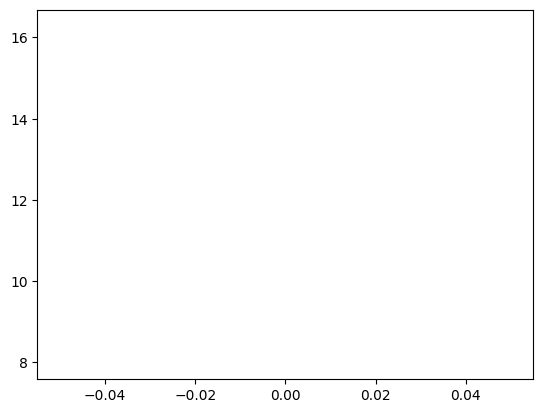

In [ ]:
plt.plot(scores)
plt.plot(t1_scores)
plt.plot(t2_scores)